# **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from wordcloud import WordCloud

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from collections import Counter

In [2]:
import torch
import torch.nn as nn

import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error


2022-01-31 21:39:45.375346: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-01-31 21:39:45.375365: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# **Loading data**

In [3]:
def loader(file, is_number = False):
    data = []
    with open(file, encoding="utf8") as my_file:
        data = my_file.read().splitlines()
    if is_number:
        data = [int(i) for i in data]
    return data

In [4]:
test_data = loader("raw/test_text.txt")
test_labels = loader("raw/test_labels.txt", True)
val_data = loader("raw/val_text.txt")
val_labels = loader("raw/val_labels.txt", True)
train_data = loader("raw/train_text.txt")
train_labels = loader("raw/train_labels.txt", True)
mappings = {0:"anger", 1:"joy", 2:"optimism",3:	"sadness"}

In [5]:
test = pd.DataFrame({"text":test_data, "label":test_labels, "emotion":[mappings[i] for i in test_labels]})
valid = pd.DataFrame({"text":val_data, "label":val_labels, "emotion":[mappings[i] for i in val_labels]})
train = pd.DataFrame({"text":train_data, "label":train_labels, "emotion":[mappings[i] for i in train_labels]})

In [6]:
train.head()

,text,label,emotion
0,“Worry is a down payment on a problem you may ...,2,optimism
1,My roommate: it's okay that we can't spell bec...,0,anger
2,No but that's so cute. Atsu was probably shy a...,1,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger
4,it's pretty depressing when u hit pan on ur fa...,3,sadness


In [7]:
test.head()

,text,label,emotion
0,#Deppression is real. Partners w/ #depressed p...,3,sadness
1,@user Interesting choice of words... Are you c...,0,anger
2,My visit to hospital for care triggered #traum...,3,sadness
3,@user Welcome to #MPSVT! We are delighted to h...,1,joy
4,What makes you feel #joyful?,1,joy


In [8]:
valid.head()

,text,label,emotion
0,"@user @user Oh, hidden revenge and anger...I r...",0,anger
1,if not then #teamchristine bc all tana has don...,0,anger
2,Hey @user #Fields in #skibbereen give your onl...,0,anger
3,Why have #Emmerdale had to rob #robron of havi...,0,anger
4,@user I would like to hear a podcast of you go...,0,anger


# **Exploratory data analysis**

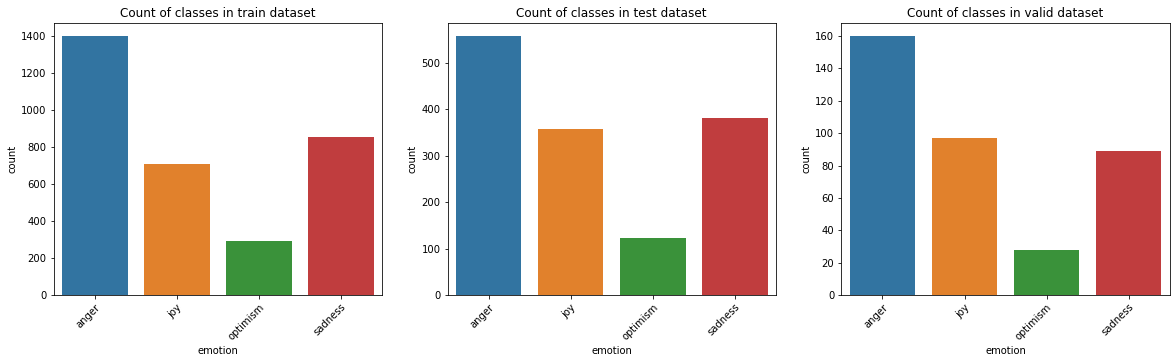

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

sns.countplot(data=train.sort_values(by=["emotion"]), x="emotion", ax = ax[0])
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

sns.countplot(data=test.sort_values(by=["emotion"]), x="emotion", ax = ax[1])
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

sns.countplot(data=valid.sort_values(by=["emotion"]), x="emotion", ax = ax[2])
plt.setp(ax[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax[0].set_title("Count of classes in train dataset")
ax[1].set_title("Count of classes in test dataset")
ax[2].set_title("Count of classes in valid dataset")

plt.show()

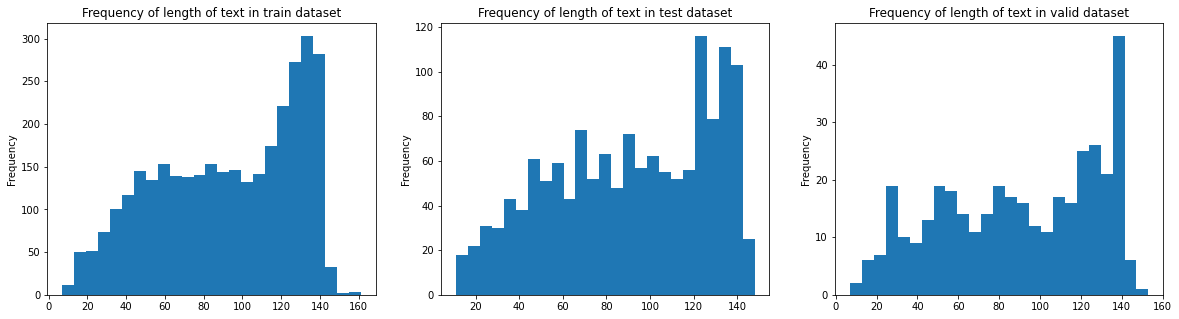

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

train["text"].apply(lambda s : len(s)).plot.hist(bins=25, ax=ax[0])
test["text"].apply(lambda s : len(s)).plot.hist(bins=25, ax=ax[1])
valid["text"].apply(lambda s : len(s)).plot.hist(bins=25, ax=ax[2])

ax[0].set_title("Frequency of length of text in train dataset")
ax[1].set_title("Frequency of length of text in test dataset")
ax[2].set_title("Frequency of length of text in valid dataset")

plt.show()

In [11]:
def counter_plots(texts, titles):
    num = len(texts)
    fig, ax = plt.subplots(nrows=1, ncols=num, figsize=(21,5))

    for i in range(num):
        sns.barplot(
            x = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in texts[i]]).split()).most_common(10)), orient="index").reset_index()["index"],
            y = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in texts[i]]).split()).most_common(10)), orient="index").reset_index()[0],
            ax = ax[i]
        )
        ax[i].set_title(titles[i])
        
    plt.show()

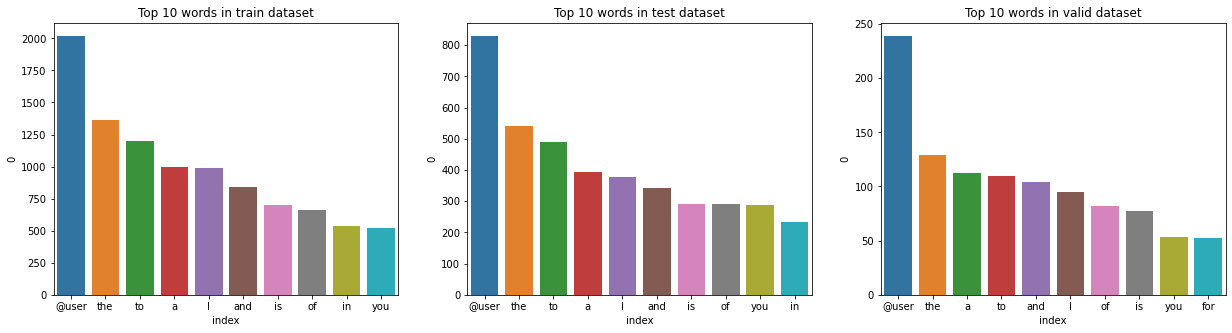

In [12]:
texts = [train["text"], test["text"], valid["text"]]
titles = ["Top 10 words in train dataset",
         "Top 10 words in test dataset",
         "Top 10 words in valid dataset"]

counter_plots(texts, titles)

# **Cleaning the data**

In [13]:
#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english')

In [14]:
def clean_text(text):
    text1 = re.sub(r'@[\w]*', '', text) # removing @user
    text2 = re.sub(r'^RT[\s]+', '', text1) # it will remove the old style retweet text "RT"
    text3 = re.sub(r'https?:\/\/.*[\r\n]*', '', text2) # it will remove hyperlinks
    text4 = re.sub(r'[^a-zA-Z#]', ' ', text3) # removing symbols
    text5 = " ".join(w for w in text4.split() if not w in stopwords_english) # removing stopwords
    text6 = " ".join(w for w in text5.split() if len(w) > 2) # removing smaller tha 3 letter words
    
    cleaned_text = text6.lower()
    return cleaned_text

In [15]:
train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)
valid["clean_text"] = valid["text"].apply(clean_text)

# **Most popular words after cleaning data**

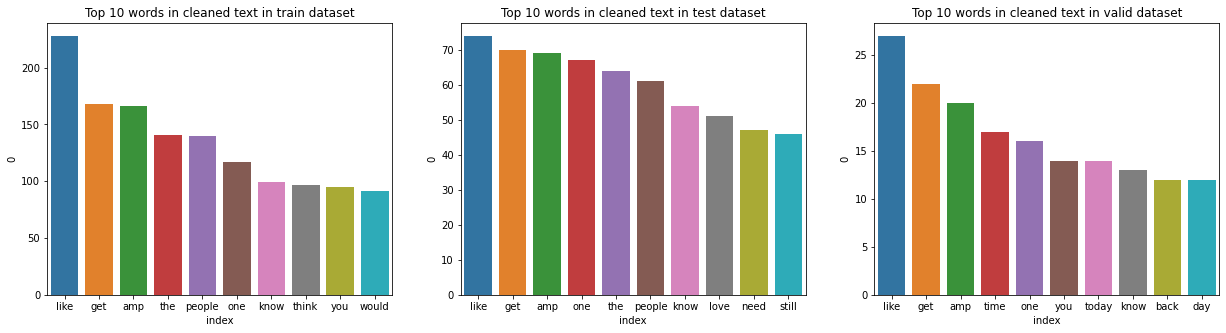

In [16]:
texts = [train["clean_text"], test["clean_text"], valid["clean_text"]]
titles = ["Top 10 words in cleaned text in train dataset",
         "Top 10 words in cleaned text in test dataset",
         "Top 10 words in cleaned text in valid dataset"]

counter_plots(texts, titles)

# **Visualizing clean text with wordclouds**

In [17]:
def word_clouds_text(texts, titles):
    num = len(texts)
    fig, ax = plt.subplots(nrows=1, ncols=num, figsize=(21,5))
    plt.tight_layout()
    
    for i in range(num):
        text_wc = WordCloud(width=800, height=600, random_state=21, max_font_size=110).generate(texts[i])
        ax[i].imshow(text_wc, interpolation="bilinear")
        ax[i].axis('off')
        ax[i].set_title(titles[i])
        
    plt.show()

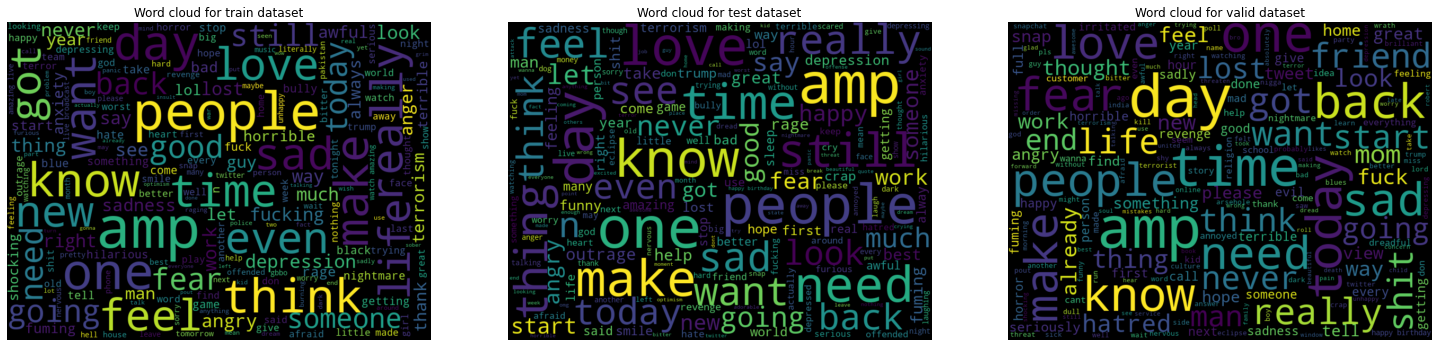

In [18]:
train_words = ' '.join([text for text in train["clean_text"]])
test_words  = ' '.join([text for text in test["clean_text"]])
valid_words = ' '.join([text for text in valid["clean_text"]])

texts = [train_words, test_words, valid_words]
titles = ["Word cloud for train dataset",
          "Word cloud for test dataset",
          "Word cloud for valid dataset"]

word_clouds_text(texts, titles)

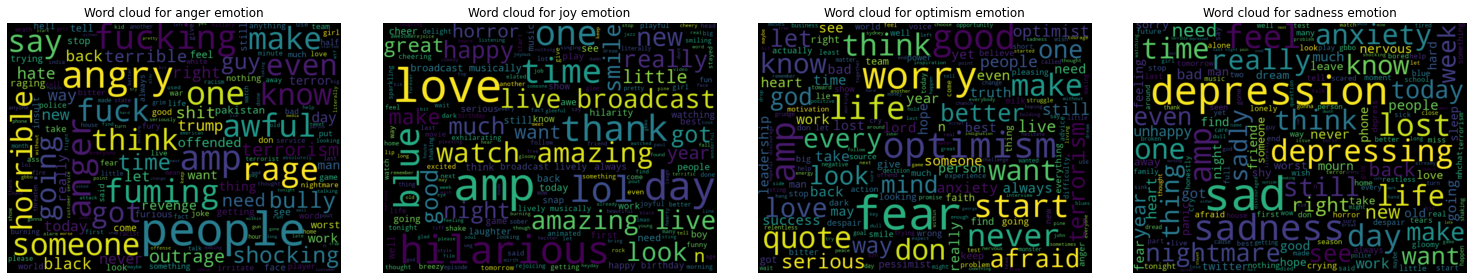

In [19]:
anger_words = ' '.join(train[train["emotion"] == "anger"]["clean_text"])
joy_words  = ' '.join(train[train["emotion"] == "joy"]["clean_text"])
optimism_words = ' '.join(train[train["emotion"] == "optimism"]["clean_text"])
sadness_words = ' '.join(train[train["emotion"] == "sadness"]["clean_text"])

texts = [anger_words, joy_words, optimism_words, sadness_words]
titles = ["Word cloud for anger emotion",
          "Word cloud for joy emotion",
          "Word cloud for optimism emotion",
          "Word cloud for sadness emotion"]

word_clouds_text(texts, titles)

In [20]:
train.head()

,text,label,emotion,clean_text
0,“Worry is a down payment on a problem you may ...,2,optimism,worry payment problem may never joyce meyer #m...
1,My roommate: it's okay that we can't spell bec...,0,anger,roommate okay spell autocorrect #terrible #fir...
2,No but that's so cute. Atsu was probably shy a...,1,joy,cute atsu probably shy photos cherry helped uwu
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger,rooneys fucking untouchable been fucking dread...
4,it's pretty depressing when u hit pan on ur fa...,3,sadness,pretty depressing hit pan favourite highlighter


In [21]:
test.head()

,text,label,emotion,clean_text
0,#Deppression is real. Partners w/ #depressed p...,3,sadness,#deppression real partners #depressed people t...
1,@user Interesting choice of words... Are you c...,0,anger,interesting choice words are confirming govern...
2,My visit to hospital for care triggered #traum...,3,sadness,visit hospital care triggered #trauma accident...
3,@user Welcome to #MPSVT! We are delighted to h...,1,joy,welcome #mpsvt delighted #grateful #mpsvt #rel...
4,What makes you feel #joyful?,1,joy,what makes feel #joyful


In [22]:
valid.head()

,text,label,emotion,clean_text
0,"@user @user Oh, hidden revenge and anger...I r...",0,anger,hidden revenge anger rememberthe time rebutted
1,if not then #teamchristine bc all tana has don...,0,anger,#teamchristine tana done provoke tweeting shad...
2,Hey @user #Fields in #skibbereen give your onl...,0,anger,hey #fields #skibbereen give online delivery s...
3,Why have #Emmerdale had to rob #robron of havi...,0,anger,why #emmerdale rob #robron first child togethe...
4,@user I would like to hear a podcast of you go...,0,anger,would like hear podcast going refuting entire ...


In [23]:
import pickle

In [25]:
train.to_pickle("pickles/train.pkl")
test.to_pickle("pickles/test.pkl")
valid.to_pickle("pickles/valid.pkl")